## "Teoría" de orbitales moleculares

Los químicos se refieren a las funciones propias del operador de Fock que 
se obtienen al intrimport psi4
import numpy as npoducir una base atómica, como **orbitales moleculares**.
Están dados por la ecuación:
\begin{equation}
\phi_i(r) = \sum_{\nu}^{AO} C_{\nu i}\psi_\nu(r)
\end{equation}
Es decir son una combinación lineal de un set de funciones base ${\psi_i}$ 
centradas sobre los distintos átomos que componen una molécula. Los coeficientes
de expansion se obtienen al resolver la ecuación Matricial de psuedo-valores propios Hartree-Fock-Roothaan
de manera iterativa para minimizar el valor esperado de la energía. Estos coeficientes 
son claves al momento de explicar la reactivadad de moleculas, como vamos a descubir en este
laboratorio.

En la tarea pasada escribimos un algoritmo que permite obtener la energía HF para moleculas, utilizando
las librerias de integrals MintsHelper que es parte del paquete de programas Psi4. Afortunadamente 
el modulo Psi4 de python permite acceder a las distinatas matrices que resultan de un calculo SCF.
Para eso primero debemos importar el modulo psi4:

In [21]:
import psi4
import numpy as np
np.set_printoptions(precision=3, suppress=True)

Luego debemos fijar la memory que usa Psi4 y numpy

In [22]:
# ==> Opciones Básicas Psi4 <==
# Memoria
psi4.set_memory(int(5e8))
numpy_memory = 500

Ahora podemos fijar la geometria de la molecula que deseamos analizar (¿En qué plano está la molecula¿):

In [27]:
# Output
psi4.core.set_output_file('output.dat', False)


mol = psi4.geometry("""
0 1
O  0.00000000 0.0000000  0.00000000
H  1.13654891 0.0000000  1.63803697
H  1.13654891 0.0000000 -1.63803697
symmetry c1
""")

Hasta ahora no hemos hecho ningun calculo, solamente fijamos parametros iniciales de la molécula. Ahora podemos 
hacer un calculo SCF del agua y guardar tanto la energía como el función de onda. También voy a imprimer los 
tipos de la energía y wfn para que sepan de que tipo de objeto se trata.

In [28]:
en, wfn = psi4.energy('scf/sto-3g', return_wfn = True)
print type(en)
print type(wfn)

<type 'float'>
<class 'psi4.core.RHF'>


Como puden ver se trata una clase psi4.core.RHF, para revisar todos los distintos atribitos que tiene la clase puede ir a: http://www.psicode.org/psi4manual/master/api/psi4.core.RHF.html. Notese que la celda anterior hace 
un calculo HF completo! Por lo tanto puede demorarse en ejecutarse, dependiendo del tamaño de la molecula y función base.

# Ejercicio 1: 

a) Obtenga la energía de la molecula, la energía de los orbitales y los coeficientes del orbital HOMO.

b) Guarde la matriz de los coeficientes de los orbitales ocupados en un array numpy e imprima la matriz redondeando los coeficientes a 3 decimas.

In [29]:
docc = wfn.doccpi().to_tuple()[0]
C = np.asarray(wfn.Ca())
C = C[:,:docc]
print C

[[ 0.995  0.261 -0.     0.022 -0.   ]
 [ 0.02  -1.019 -0.    -0.104  0.   ]
 [ 0.     0.001  0.     0.793 -0.   ]
 [ 0.     0.     1.    -0.    -0.   ]
 [-0.    -0.     0.     0.     0.565]
 [-0.001 -0.048  0.     0.393  0.548]
 [-0.001 -0.048  0.     0.393 -0.548]]


La matriz de coefiecientes nos entrga la información de como están construidos los 
obritales moleculares a partir de la base atómica. Un ojo muy adiestrado puede de inmediato decir de que
molecula se trata solamente la matriz de coeficientes.¿Qué pueden inferir usteds de la matriz de los coeficientes?

El químico comun y corriente tiene una inteligencia más... ehm... visual, por eso conviene muchas veces 
visualizar los distintos orbitales. La mayoría de las veces lo que se hace es calcular la función (1) sobre una grilla utlizando los coeficientes de los orbitales y visualizar isosuperficies, es decir superficies de puntos que tienen igual densidad. Sin embargo nosotros vamos a graficar los funciones de fock en diferentes planos moleculares, similar a lo que hicimos con el átomo de Helio.

Primero tenemos que definir una grilla sobre la cual vamos a graficar los orbitales, y guardar las coordenadas de los núecleos en un array de numpy.

In [33]:
#Coordenadas XYZ
XYZ = np.asarray(mol.geometry())
print XYZ
# Notese que el programa movio la molecula al plano yz por lo que hay que 
# hacer una grilla en el plano yz. 

# Grilla para graficar el orbital
xyz = [0.0, np.linspace(-8.0,8.0,100),np.linspace(-8.0,8.0,100)]
Y1,Z1 = np.meshgrid(xyz[1], xyz[2])
xyz_1 = [0.00,Y1,Z1] 



[[ 0.     0.    -0.24 ]
 [ 0.     3.095  1.907]
 [ 0.    -3.095  1.907]]


Ahora debemos definir las funciones necesarias para calcular las funciones bases. (Vease lab de funciones bases)

In [34]:
from scipy.special import factorial2

def r_R(x,y,z,X,Y,Z):
    return (np.sqrt((x-X)**2+(y-Y)**2+(z-Z)**2))

def N(alpha,a,b,c):
    return (2.0/np.pi)**(0.75)*(2.0**(a+b+c)*alpha**((2.0*a+2.0*b+2.0*c+3.0)/4.0))/(factorial2(2*a-1)*factorial2(2*b-1)*factorial2(2*c-1))**(0.5)

def GTO(alpha,xyz,XYZ,a,b,c):
    return N(alpha,a,b,c)*(xyz[0]**a)*(xyz[1]**b)*(xyz[2]**c)*np.exp(-alpha*(r_R(xyz[0],xyz[1],xyz[2],XYZ[0],XYZ[1],XYZ[2])**2.0))

def sto_xg(alpha_l,c_l,xyz,XYZ,a,b,c,*argv):
    sto = 0.0
    for i in range(len(c_l)):
        sto += c_l[i]*GTO(alpha_l[i],xyz,XYZ,a,b,c)
    return sto


In [35]:
Finalmente podemos construir el orbital molecular a partir de los coeficientes dados en la 
matriz de coeficientes:

SyntaxError: invalid syntax (<ipython-input-35-6430993fc65e>, line 1)

In [36]:
def MO(xyz,XYZ,coef):
    _1s_H_exp = [3.42525091,0.62391373, 0.16885540]
    _1s_H_coef = [0.15432897,0.53532814, 0.44463454]

    _1s_O_exp = [130.7093200,23.808610, 6.4436083]
    _1s_O_coef = [0.15432897,0.53532814, 0.44463454]

    _2s_O_exp = [5.0331513,1.1695961, 0.3803890]
    _2s_O_coef = [-0.09996723,0.39951283,0.70011547]

    _2p_O_exp = [5.0331513,1.1695961, 0.3803890]
    _2p_O_coef = [0.155591627,0.60768372,0.39195739]
    return coef[0]*sto_xg(_1s_O_exp,_1s_O_coef,xyz,XYZ[0],0,0,0) + coef[1]*sto_xg(_2s_O_exp,_2s_O_coef,xyz,XYZ[0],0,0,0) + coef[2]*sto_xg(_2p_O_exp,_2p_O_coef,xyz,XYZ[0],0,0,1)+coef[3]*sto_xg(_2p_O_exp,_2p_O_coef,xyz,XYZ[0],1,0,0) + coef[4]*sto_xg(_2p_O_exp,_2p_O_coef,xyz,XYZ[0],0,1,0) + coef[5]*sto_xg(_1s_H_exp,_1s_H_coef,xyz,XYZ[1],0,0,0) + coef[6]*sto_xg(_1s_H_exp,_1s_H_coef,xyz,XYZ[2],0,0,0)


Notese lo artesanal que esta construida esta función.  Solamente se puede usar para el caso particular que 
estamos viendo. Ahora lo último que necesitamos es tener una función que nos grafique la función sobre la grilla que definimos. 

In [40]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import matplotlib.pyplot as plt
%matplotlib inline

def plot_3D(xyz,XYZ,coef,func):
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    surf = ax.plot_surface(xyz[1],xyz[2],func(xyz,XYZ,coef), cmap=cm.coolwarm,
                              linewidth=0, antialiased=False)

# Ejercicio 2

Grafique los orbitales ocupados del $H_2O$. ¿Que puede concluir sobre el enlace químico?

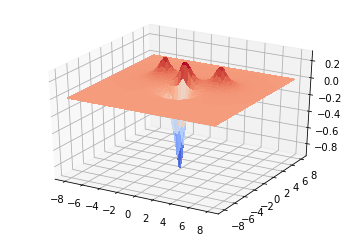

In [43]:
coef = C[:,3]
plot_3D(xyz_1,XYZ,coef,MO)

# Bonus Track

Calcule las cargas de Mulliken sobre los átomos